# Лабораторная работа №5. Шут Артём

In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as la
from matplotlib import pyplot as plt
from prettytable import PrettyTable as pt
from scipy.misc import derivative as deriv
from scipy.integrate import quad

## Задание 1.

In [2]:
def left_difference_method(func, x, n=1, dx=1e-3):
    if n == 1:
        return (func(x) - func(x - dx)) / dx
    else:
        return (left_difference_method(func, x, n - 1) - \
                left_difference_method(func, x - dx, n - 1)) / dx

def right_difference_method(func, x, n=1, dx = 1e-3):
    if n == 1:
        return (func(x + dx) - func(x)) / dx
    else:
        return (right_difference_method(func, x + dx, n - 1) - \
                right_difference_method(func, x, n - 1)) / dx
    
def two_way_difference_method(func, x, n=1, dx=2e-3):
    if n == 1:
        return (func(x + dx) - func(x - dx)) / (2*dx)
    else:
        return (two_way_difference_method(func, x + dx, n - 1) - \
                two_way_difference_method(func, x - dx, n - 1)) / (2*dx)

In [3]:
def f_0(x):
    return np.exp(2 * x) * np.cos(3 * x)
def f_1(x):
    return np.sin(np.log(x))
def f_2(x):
    return np.log(x)
def f_3(x):
    return np.sin(x) + np.cos(x)
funcs = [f_0, f_1, f_2, f_3]
borders = [
    [0.0, 0.3], 
    [2.0, 2.4], 
    [1.0, 1.1], 
    [0.0, 0.25],   
    ]
titles = [
    'f(x) = exp(2x)*cos(3x), x in [0, 0.3]',
    'f(x) = sin(ln(x)), x in [2.0, 2.4]',
    'f(x) = ln(x), x in [1, 1.1]',
    'f(x) = cos(x) + sin(x), x in [0, 0.25]'
]
types = [
    'f\'(0.25)',
    'f\'(0.51)',
    'f\'\'(0.99)',
    'f\'\'(1.09)',
    'f\'\'\'(1.89)',
    'f\'\'\'(2.39)',
]
xs = [0.25, 0.51, 0.99, 1.09, 1.89, 2.39]
ns = [1,1,2,2,3,3]
fields = [
        "Тип производной", 
        "Ошибка метода правосторонней разности", 
        "Ошибка метода левосторонней разности", 
        "Ошибка метода двусторонней разности", 
        "Результат numpy"
    ]
field_names = [
        "type", 
        "right", 
        "left", 
        "two", 
        "scipy"
    ]
tables = [pt(field_names) for _ in range(4)]

with_borders = False
for f, b, t in zip(funcs, borders, tables):
    for type, x, n in zip(types, xs, ns):
        field = [type] 
        if with_borders and (x < b[0] or x > b[1]):
            field += ['-' for _ in range(4)]
        else:
            mean = deriv(f, x, dx=1e-4, n=n, order=5)
            field += [
                "%.7f" % abs(right_difference_method(f, x, n) - mean),
                "%.7f" % abs(left_difference_method(f, x, n) - mean),
                "%.7f" % abs(two_way_difference_method(f, x, n) - mean),
                "%.7f" % mean
            ]
        t.add_row(field)
        
t = pt(['field_names','fields'])
for f,fn in zip(field_names, fields):
    t.add_row([f, fn])
print(t)
            
for i,t,title in zip(range(4),tables, titles):
    print('')
    print(title)
    print(t)

+-------------+---------------------------------------+
| field_names |                 fields                |
+-------------+---------------------------------------+
|     type    |            Тип производной            |
|    right    | Ошибка метода правосторонней разности |
|     left    |  Ошибка метода левосторонней разности |
|     two     |  Ошибка метода двусторонней разности  |
|    scipy    |            Результат numpy            |
+-------------+---------------------------------------+

f(x) = exp(2x)*cos(3x), x in [0, 0.3]
+------------+------------+------------+-----------+---------------+
|    type    |   right    |    left    |    two    |     scipy     |
+------------+------------+------------+-----------+---------------+
|  f'(0.25)  | 0.0097698  | 0.0097479  | 0.0000437 |   -0.9587950  |
|  f'(0.51)  | 0.0169131  | 0.0169030  | 0.0000201 |   -8.0864524  |
| f''(0.99)  | 0.3177247  | 0.3165610  | 0.0013301 |   20.8413436  |
| f''(1.09)  | 0.4143042  | 0.4132452  | 0.

## Задание 2.

### Классы для работы со сплайнами и МНК

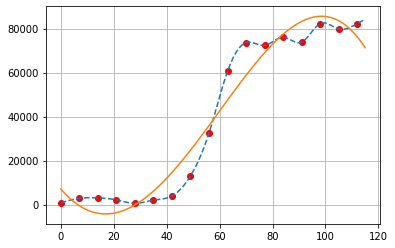

In [4]:
class Spline:    
    def init(self, xs, ys):        
        n = len(xs)
        h = np.diff(xs)
        df = np.diff(ys)
        A = np.zeros((n, n))
        B = np.zeros((n, ))
        A[0, 0] = 1
        A[n-1, n-1] = 1
        for i in range(1, n-1):
            A[i, i - 1] = h[i-1]
            A[i][i] = 2 * (h[i-1] + h[i])
            A[i, i + 1] = h[i]
            B[i] = 3 * (df[i] / h[i] - df[i - 1] / h[i - 1])
        c = np.linalg.solve(A, B)
        d = np.zeros((n - 1,))
        b = np.zeros((n - 1,))
        for i in range(0, len(d)):
            d[i] = (c[i + 1] - c[i]) / (3 * h[i])
            b[i] = (df[i] / h[i]) - (h[i] / 3) * (2 * c[i] + c[i + 1])
        self._xs = xs.copy()
        self._ys = ys.copy()
        self._b = b
        self._c = c
        self._d = d
        
    def func(self, x):            
        for i in range(0, len(self._xs) - 1):
            if x <= self._xs[i+1]:
                break                
                     
        return self._ys[i] + self._b[i]*(x - self._xs[i]) + \
                self._c[i]*(x - self._xs[i])**2 + \
                self._d[i]*(x - self._xs[i])**3

class MNK:    
    k = 5
    def init(self, xs, ys):        
        n = len(xs)        
        Y = np.array(ys)
        X = np.ones((n, self.k))
        for i in range(n):
            for j in range(self.k):
                X[i][j] = xs[i]**j
        
        A = np.dot(X.transpose(), X)
        Y = np.dot(X.transpose(), Y)
        self.a = np.linalg.solve(A, Y)
        
    def func(self, x):
        return sum([self.a[i] * x**i for i in range(self.k)])
    
spline = Spline()
mnk = MNK()

data = pd.read_excel("cases.xls")
data = np.array(data)
cases = np.array([d[0] for d in data])

days = np.array(range(len(cases)))
cases = np.array(cases)[::7]
weeks = days[::7]
plt.plot(weeks, cases,'ro')

x = np.linspace(days[0], days[-1], 100)
spline.init(weeks, cases)
mnk.init(weeks, cases)

y_spline = [spline.func(i) for i in x]
y_mnk = [mnk.func(i) for i in x]

plt.plot(x, y_spline, '--', x, y_mnk, '-')
plt.grid(True) 

plt.show()

### Рассмотрим методы трапеции и средней точки

In [5]:
def trapezoidal(func, a, b, n=1000):
    xs = np.linspace(a, b, n + 1)
    ys = [func(x) for x in xs]
    return (b - a) * sum(ys[1:] + ys[:-1]) / (2 * n)

def mid_point(func, a, b, n=1000):
    h = (b - a) / n
    x = a + h/2       
    return sum([func(x + i*h)*h for i in range(n)])

In [6]:
def print_table(func, a, b):
    table = pt(['Интеграл', 'Значение интеграла', 'Ошибка'])
    scipy_res, err = quad(func, a, b)
    trap_res = trapezoidal(func, a, b, 1000)
    mid_p_res = mid_point(func, a, b, 1000)
    table.add_row(['Scipy', scipy_res, '-'])
    table.add_row(['Трапеции', trap_res, abs(trap_res-scipy_res)/scipy_res])
    table.add_row(['Средней точки', mid_p_res, abs(mid_p_res-scipy_res)/scipy_res ])
    print(table)
    
a, b = days[0], days[-1]

In [7]:
print('\t\t\tSpline')
print_table(spline.func, a, b)

			Spline
+---------------+--------------------+------------------------+
|    Интеграл   | Значение интеграла |         Ошибка         |
+---------------+--------------------+------------------------+
|     Scipy     | 4588090.394979787  |           -            |
|    Трапеции   | 4588090.566471912  | 3.7377669170449707e-08 |
| Средней точки | 4588090.339047482  | 1.2190759119111663e-08 |
+---------------+--------------------+------------------------+


In [8]:
print('\t\t\tMNK')
print_table(mnk.func, a, b)

			MNK
+---------------+--------------------+------------------------+
|    Интеграл   | Значение интеграла |         Ошибка         |
+---------------+--------------------+------------------------+
|     Scipy     | 4560611.8564830655 |           -            |
|    Трапеции   | 4560611.337846525  | 1.1372082449255155e-07 |
| Средней точки | 4560612.115801162  | 5.686037416110965e-08  |
+---------------+--------------------+------------------------+


#### Вывод: 
Оба метода имеют кубическую сходимость, однако метод трапеций чаще даёт более точный результат, так как верхняя оценка его остаточного члена $ f'(\xi)\frac{(b-a)^3}{12} $, тогда когда у метода премоугольников $ f'(\xi)\frac{(b-a)^3}{24} $